In [ ]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import KBinsDiscretizer
import shap
from sklearn.ensemble import RandomForestClassifier

#------------------------------------Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import joblib 



spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")
pd.set_option('display.max_columns', 500)

#--------------------Model

import importlib
import modeling_utils
importlib.reload(modeling_utils) 
from eda_utils import calculate_psi, plot_distribution_plotly, calculate_woe_iv

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, f1_score, confusion_matrix, roc_curve, auc, precision_score, recall_score,  brier_score_loss
from modeling_utils import plot_model_evaluation_summary, generate_classification_report
import joblib
from risk_validation_phase1 import *


# Global Variables 

In [4]:
lr_training_vars = [ 'home_ownership', 'addr_state', 'dti', 'fico_range_high', 'all_util',
       'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_rev_tl',
       'emp_length_numeric', 'emp_title_final_grouped', 'title_grouped',
       'region_median_income', 'loan_to_income_ratio', 'open_acc_ratio']

print('Len of the features', len(lr_training_vars))

xgboost_training_vars = ['loan_amnt', 'home_ownership', 'annual_inc', 'addr_state', 'dti',
       'fico_range_high', 'all_util', 'inq_last_12m', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_actv_rev_tl', 'emp_length_numeric',
       'emp_title_final_grouped', 'title_grouped', 'region_median_income',
       'loan_to_income_ratio', 'open_acc_ratio']
       


print('Len of the features', len(xgboost_training_vars))


Len of the features 21
Len of the features 23


# Global Functions

In [5]:
def calculate_model_scores(df):
    """
    Calcula los scores calibrados para todos los modelos
    
    Parameters:
    df: DataFrame con los datos de entrada
    
    Returns:
    DataFrame original con columnas adicionales de scores
    """
    
    # Crear una copia del DataFrame para no modificar el original
    df_scores = df.copy()
    
    # 1. Baseline Model Score
    X_lr = df[lr_training_vars]
    baseline_proba = base_model.predict_proba(X_lr)[:, 1]
    df_scores['baseline_score'] = base_model_cal.predict(baseline_proba)
    
    # 2. Weighted Model Score
    weighted_proba = weighted_model.predict_proba(X_lr)[:, 1]
    df_scores['weighted_score'] = weighted_model_cal.predict(weighted_proba)
    
    # 3. Undersampled Model Score
    under_proba = under_model.predict_proba(X_lr)[:, 1]
    df_scores['undersampled_score'] = under_model_cal.predict(under_proba)
    
    # 4. XGBoost Model Score (con variables adicionales)
    X_xgb = df[xgboost_training_vars]
    xgb_proba = xgboost_model.predict_proba(X_xgb)[:, 1]
    df_scores['xgboost_score'] = xgboost_model_cal.predict(xgb_proba)
    
    return df_scores

# Load models

In [6]:

xgboost_model =  joblib.load('final_xgboost_model.joblib', 'wb')

xgboost_model_cal = joblib.load('xgboost_isotonic_calibrator.joblib')

#-------------------------------------------------------------------------------------------------------------

base_model = joblib.load('final_logistic_model.joblib')

base_model_cal = joblib.load('lr_isotonic_calibrator.joblib')



weighted_model = joblib.load('final_logistic_model_weights.joblib')

weighted_model_cal = joblib.load('lr_isotonic_calibrator_weights.joblib')



under_model = joblib.load('final_logistic_model_undersampling.joblib')

under_model_cal = joblib.load('lr_isotonic_calibrator_undersampling.joblib')



# Load data

In [7]:
df = pd.read_csv('df_total_woe_validations.csv').rename(columns={'funded_amnt':'loan_amnt'})

df['d_vintage'] = pd.to_datetime(df['d_vintage'])


df = df.drop(['int_rate'], axis=1)
print('Dimension of the data:', df.shape)

Dimension of the data: (2260698, 33)


# Calculating the scores

In [8]:
df_with_scores = calculate_model_scores(df)

df_filter = df_with_scores[df_with_scores['d_vintage']>=pd.to_datetime('2016-07-01') ]

print('Dimension filtered data', df_filter.shape)


Dimension filtered data (1141486, 37)


# Loan amount USD

In [ ]:
df_loan_amnt = spark.sql("""select id, issue_d, funded_amnt as real_loan_amnt, int_rate , term , total_rec_prncp,
recoveries, collection_recovery_fee from data_credit_test_ds_chanllenges""").toPandas()


df_loan_amnt['term'] = df_loan_amnt['term'].str.extract('(\d+)')


df_loan_amnt['d_vintage'] = pd.to_datetime(df_loan_amnt['issue_d'], format='%b-%Y')

df_filter = df_filter.merge(df_loan_amnt, on=['id', 'd_vintage'], how='left').drop_duplicates()

In [10]:
df_filter = df_filter.drop(['loan_amnt', 'term_numeric'], axis=1)

df_filter['term'] = df_filter['term'].astype(float)

df_filter_target = df_filter[df_filter['target'].notna()]

# Risk Analysis

### LGD

Total loans: 343827
Defaulted loans: 77515 (22.54%)
Average LGD: 0.0838
Weighted average LGD: 0.7704


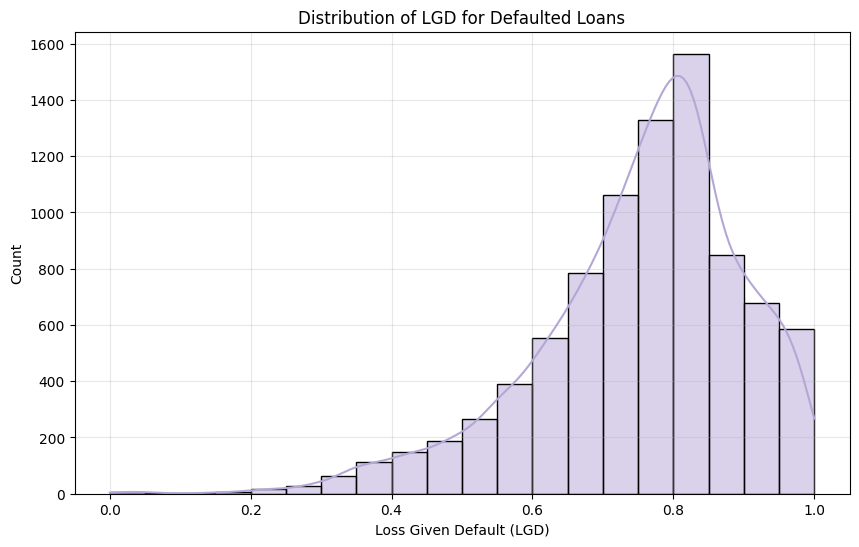

Weighted average LGD for defaulted loans: 0.7713


In [11]:
# Función para calcular el LGD a nivel de préstamo con las columnas disponibles
def calculate_lgd(df):
    """
    Calculate Loss Given Default (LGD) for each loan in the DataFrame.
    
    Parameters:
    - df: DataFrame with loan data
    
    Returns:
    - DataFrame with added 'loss_amount' and 'lgd' columns
    """
    # Create a copy to avoid modifying the original DataFrame
    result_df = df.copy()
    
    # Step 1: Identify defaulted loans (assuming target=1 means default)
    defaulted_mask = result_df['target'] == 1
    
    # Step 2: Calculate loss amount for all loans (will be 0 for non-defaulted loans)
    result_df['loss_amount'] = 0.0
    
    # Calculate loss amount only for defaulted loans using available columns
    result_df.loc[defaulted_mask, 'loss_amount'] = (
        result_df.loc[defaulted_mask, 'real_loan_amnt'] - 
        result_df.loc[defaulted_mask, 'total_rec_prncp'] - 
        result_df.loc[defaulted_mask, 'recoveries'] 
    ).clip(lower=0)
    
    # Step 3: Calculate LGD for each loan
    result_df['lgd'] = 0.0
    non_zero_funded = (result_df['real_loan_amnt'] > 0) & defaulted_mask
    result_df.loc[non_zero_funded, 'lgd'] = (
        result_df.loc[non_zero_funded, 'loss_amount'] / 
        result_df.loc[non_zero_funded, 'real_loan_amnt']
    ).clip(lower=0, upper=1)  # LGD should be between 0 and 1
    
    # Step 4: Calculate portfolio-level statistics
    total_defaulted = defaulted_mask.sum()
    avg_lgd = result_df.loc[defaulted_mask, 'lgd'].mean() if total_defaulted > 0 else 0
    weighted_lgd = (
        (result_df.loc[defaulted_mask, 'lgd'] * result_df.loc[defaulted_mask, 'real_loan_amnt']).sum() / 
        result_df.loc[defaulted_mask, 'real_loan_amnt'].sum()
    ) if total_defaulted > 0 else 0
    
    print(f"Total loans: {len(result_df)}")
    print(f"Defaulted loans: {total_defaulted} ({total_defaulted/len(result_df)*100:.2f}%)")
    print(f"Average LGD: {avg_lgd:.4f}")
    print(f"Weighted average LGD: {weighted_lgd:.4f}")
    
    return result_df

# Ejemplo de uso
df_with_lgd = calculate_lgd(df_filter_target )



#----------Plot--------------------------------------------------------------------------------
defaulted_loans = df_with_lgd[df_with_lgd['lgd'] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(defaulted_loans['lgd'], bins=20, kde=True, color='#b4a7d6')
plt.title('Distribution of LGD for Defaulted Loans')
plt.xlabel('Loss Given Default (LGD)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# También puedes calcular el LGD promedio ponderado para usar en tus análisis
weighted_lgd = (
    (defaulted_loans['lgd'] * defaulted_loans['real_loan_amnt']).sum() / 
    defaulted_loans['real_loan_amnt'].sum()
)
print(f"Weighted average LGD for defaulted loans: {weighted_lgd:.4f}")

In [12]:
import importlib
import risk_validation_phase1
importlib.reload(risk_validation_phase1)
from risk_validation_phase1 import *

# Ejecutar la Fase 1 con tasas de interés, LGD y términos específicos por préstamo
results_phase1 = execute_phase1_risk_validation(
    df_with_lgd,
    interest_rate_col='int_rate',  # Usar tasas de interés específicas por préstamo
    cutoff_decile=6,   
    term_col='term',
    lgd_col='lgd'            # Punto de corte para análisis de política

)

# Las 4 visualizaciones principales
results_phase1['visualizations']['dashboard'].show()                    # 📊 Métricas básicas
results_phase1['visualizations']['lift_heatmap'].show()                # 🎨 Heatmap de lift
results_phase1['visualizations']['default_capture_efficiency'].show()  # 📈 Captura de defaults
results_phase1['visualizations']['loss_capture_efficiency'].show()     # 💰 Captura de pérdidas


🎯 EXECUTING PHASE 1: RISK VALIDATION ANALYSIS
PHASE 1: RISK VALIDATION - STANDARD QCUT DECILES
Using 343,827 Test observations with target for validation

Decile distribution for Baseline (Test set):
  Decile 1: 37,903 observations (11.0%)
  Decile 2: 34,319 observations (10.0%)
  Decile 3: 32,401 observations (9.4%)
  Decile 4: 34,432 observations (10.0%)
  Decile 5: 34,573 observations (10.1%)
  Decile 6: 42,044 observations (12.2%)
  Decile 7: 30,864 observations (9.0%)
  Decile 8: 29,999 observations (8.7%)
  Decile 9: 36,347 observations (10.6%)
  Decile 10: 30,945 observations (9.0%)
Score boundaries for Baseline:
  Decile 1: 0.0000 to 0.0737
  Decile 2: 0.0744 to 0.1039
  Decile 3: 0.1084 to 0.1267
  ... (showing first 3 deciles)
✓ Successfully created Baseline_decile

Decile distribution for Weighted (Test set):
  Decile 1: 34,896 observations (10.1%)
  Decile 2: 36,564 observations (10.6%)
  Decile 3: 40,628 observations (11.8%)
  Decile 4: 25,827 observations (7.5%)
  Decile 

In [38]:


risk_xgboost = risk_results[ 'Xgboost']['decile_metrics'][['decile', 'cumulative_defaults_pct',  'cumulative_expected_loss']].rename(columns={'cumulative_defaults_pct':'cumulative_defaults_pct_xgboost', 'cumulative_expected_loss':'cumulative_expected_loss_xgboost'}).set_index(['decile'])
risk_weighted= risk_results[ 'Weighted']['decile_metrics'][['decile', 'cumulative_defaults_pct',  'cumulative_expected_loss']].rename(columns={'cumulative_defaults_pct':'cumulative_defaults_pct_weighted', 'cumulative_expected_loss':'cumulative_expected_loss_weighted'}).set_index(['decile'])
risk_baseline = risk_results[ 'Baseline']['decile_metrics'][['decile', 'cumulative_defaults_pct',  'cumulative_expected_loss']].rename(columns={'cumulative_defaults_pct':'cumulative_defaults_pct_baseline', 'cumulative_expected_loss':'cumulative_expected_loss_baseline'}).set_index(['decile'])
risk_under = risk_results[ 'Undersampled']['decile_metrics'][['decile', 'cumulative_defaults_pct',  'cumulative_expected_loss']].rename(columns={'cumulative_defaults_pct':'cumulative_defaults_pct_under', 'cumulative_expected_loss':'cumulative_expected_loss_under'}).set_index(['decile'])


df_total= pd.concat([risk_xgboost,risk_weighted,risk_baseline,risk_under], axis=1)


df_total['cumulative_expected_loss_xgboost'] = (df_total['cumulative_expected_loss_xgboost']/(df_total['cumulative_expected_loss_xgboost'].max())*100)
df_total['cumulative_expected_loss_weighted'] = (df_total['cumulative_expected_loss_weighted']/(df_total['cumulative_expected_loss_weighted'].max())*100)
df_total['cumulative_expected_loss_baseline'] = (df_total['cumulative_expected_loss_baseline']/(df_total['cumulative_expected_loss_baseline'].max())*100)
df_total['cumulative_expected_loss_under']  = (df_total['cumulative_expected_loss_under']/(df_total['cumulative_expected_loss_under'].max())*100)

In [40]:
df_total.reset_index()

,decile,cumulative_defaults_pct_xgboost,cumulative_expected_loss_xgboost,cumulative_defaults_pct_weighted,cumulative_expected_loss_weighted,cumulative_defaults_pct_baseline,cumulative_expected_loss_baseline,cumulative_defaults_pct_under,cumulative_expected_loss_under
0,1,2.27,1.87,2.92,2.50,3.25,2.83,3.80,2.98
1,2,6.60,4.94,8.33,7.60,8.44,7.66,8.10,6.35
2,3,12.65,9.29,16.09,14.00,14.48,12.62,15.70,12.65
3,4,19.88,15.25,21.86,19.60,22.11,19.79,23.06,19.31
4,5,29.39,23.73,31.60,28.33,30.94,27.81,33.67,28.90
5,6,40.52,34.21,41.17,37.32,43.45,39.62,42.22,37.16
6,7,51.11,43.83,54.94,50.35,54.04,49.56,52.87,47.35
7,8,64.24,56.94,64.99,60.26,65.55,60.88,67.65,61.79
8,9,81.48,76.31,81.40,77.42,81.98,78.31,82.04,77.59
9,10,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [31]:
df_total

,cumulative_defaults_pct_xgboost,cumulative_expected_loss_xgboost,cumulative_defaults_pct_weighted,cumulative_expected_loss_weighted,cumulative_defaults_pct_baseline,cumulative_expected_loss_baseline,cumulative_defaults_pct_under,cumulative_expected_loss_under
decile,,,,,,,,
1,2.27,0.02,2.92,0.02,3.25,0.03,3.80,2460465.00
2,6.60,0.05,8.33,0.08,8.44,0.08,8.10,5254620.00
3,12.65,0.09,16.09,0.14,14.48,0.13,15.70,10456140.00
4,19.88,0.15,21.86,0.20,22.11,0.20,23.06,15969210.00
5,29.39,0.24,31.60,0.28,30.94,0.28,33.67,23895090.00
6,40.52,0.34,41.17,0.37,43.45,0.40,42.22,30727275.00
7,51.11,0.44,54.94,0.50,54.04,0.50,52.87,39156015.00
8,64.24,0.57,64.99,0.60,65.55,0.61,67.65,51089115.00
9,81.48,0.76,81.40,0.77,81.98,0.78,82.04,64154670.00


## Model financial impact comparisson

### Point cut

### Policy

In [15]:
df_with_deciles, decile_info  = create_simple_qcut_deciles(  df_with_lgd)

PHASE 1: RISK VALIDATION - STANDARD QCUT DECILES
Using 343,827 Test observations with target for validation

Decile distribution for Baseline (Test set):
  Decile 1: 37,903 observations (11.0%)
  Decile 2: 34,319 observations (10.0%)
  Decile 3: 32,401 observations (9.4%)
  Decile 4: 34,432 observations (10.0%)
  Decile 5: 34,573 observations (10.1%)
  Decile 6: 42,044 observations (12.2%)
  Decile 7: 30,864 observations (9.0%)
  Decile 8: 29,999 observations (8.7%)
  Decile 9: 36,347 observations (10.6%)
  Decile 10: 30,945 observations (9.0%)
Score boundaries for Baseline:
  Decile 1: 0.0000 to 0.0737
  Decile 2: 0.0744 to 0.1039
  Decile 3: 0.1084 to 0.1267
  ... (showing first 3 deciles)
✓ Successfully created Baseline_decile

Decile distribution for Weighted (Test set):
  Decile 1: 34,896 observations (10.1%)
  Decile 2: 36,564 observations (10.6%)
  Decile 3: 40,628 observations (11.8%)
  Decile 4: 25,827 observations (7.5%)
  Decile 5: 37,999 observations (11.1%)
  Decile 6: 32,

In [16]:
risk_results = calculate_comprehensive_risk_metrics(df_with_deciles)

Filtering diagnostics:
Total rows in dataset: 343,827
Test set rows: 343,827 (100.0% of total)
Test set with non-null target: 343,827 (100.0% of Test set)

Calculating comprehensive risk metrics for Test set...
Test set size: 343,827 observations

Found 4 decile columns: ['Baseline_decile', 'Weighted_decile', 'Undersampled_decile', 'Xgboost_decile']
Overall Statistics:
  Default Rate: 0.225 (22.5%)
  Total Defaults: 77,515.0
  Total Exposure: $553,574,625

Analyzing Baseline model...
Decile distribution for Baseline:
  Decile 1: 37,903 loans (11.0%)
  Decile 2: 34,319 loans (10.0%)
  Decile 3: 32,401 loans (9.4%)
  Decile 4: 34,432 loans (10.0%)
  Decile 5: 34,573 loans (10.1%)
  Decile 6: 42,044 loans (12.2%)
  Decile 7: 30,864 loans (9.0%)
  Decile 8: 29,999 loans (8.7%)
  Decile 9: 36,347 loans (10.6%)
  Decile 10: 30,945 loans (9.0%)

Summary for Baseline:
  Total loans: 343,827
  Total defaults: 77,515.0
  Overall default rate: 22.54%

  Decile 6 cutoff metrics:
    Approved loans

In [18]:
def visualize_economic_value_with_smoothing(risk_results, baseline_model='Baseline', window_size=3):
    """
    Visualize economic value analysis using the pre-calculated cumulative_expected_loss column
    with smoothing applied to reduce fluctuations
    
    Parameters:
    - risk_results: Dictionary with risk analysis results by model
    - baseline_model: Name of the baseline model
    - window_size: Size of the window for moving average smoothing
    
    Returns:
    - Plotly figure
    """
    import plotly.graph_objects as go
    import numpy as np
    import pandas as pd
    
    # Define colors for models
    colors = {
        'Baseline':  '#1560bd',   
        'Weighted': '#75caed',     
        'Undersampled':  '#8B7EC8', 
        'Xgboost': '#d62728'        
    }
    
    # Get baseline results with cumulative expected loss
    baseline_results = risk_results[baseline_model]['decile_metrics']
    baseline_cumulative = baseline_results['cumulative_expected_loss'].tolist()
    
    # Create figure
    fig = go.Figure()
    
    # Function to apply moving average smoothing
    def apply_smoothing(data, window_size):
        # If window_size is too large for our data, reduce it
        actual_window = min(window_size, len(data))
        if actual_window <= 1:
            return data
        
        # Use pandas rolling mean for smoothing
        return pd.Series(data).rolling(window=actual_window, center=True).mean().fillna(method='bfill').fillna(method='ffill').tolist()
    
    # Process each model
    economic_data = []
    
    for model, data in risk_results.items():
        if model == baseline_model:
            continue
            
        # Get this model's cumulative expected loss
        model_cumulative = data['decile_metrics']['cumulative_expected_loss'].tolist()
        
        # Calculate economic value (difference in cumulative expected loss)
        economic_value = [baseline_cumulative[i] - model_cumulative[i] for i in range(len(baseline_cumulative))]
        
        # Apply smoothing
        smoothed_value = apply_smoothing(economic_value, window_size)
        
        economic_data.append({
            'model': model,
            'deciles': list(range(1, 11)),
            'cumulative_value': economic_value,
            'smoothed_value': smoothed_value
        })
    
    # Add traces for each model - both raw and smoothed
    for data in economic_data:
        # Raw data (with lower opacity)
        fig.add_trace(go.Scatter(
            x=data['deciles'],
            y=data['cumulative_value'],
            mode='lines+markers',
            name=f'{data["model"]} (Raw)',
            line=dict(color=colors.get(data['model'], '#000000'), width=1, dash='dot'),
            marker=dict(size=4),
            opacity=0.5,
            showlegend=False
        ))
        
        # Smoothed data
        fig.add_trace(go.Scatter(
            x=data['deciles'],
            y=data['smoothed_value'],
            mode='lines+markers',
            name=f'{data["model"]} vs {baseline_model}',
            line=dict(color=colors.get(data['model'], '#000000'), width=2),
            marker=dict(size=6)
        ))
    
    # Add zero line
    fig.add_hline(y=0, line_dash="dash", line_color="gray", 
                  annotation_text=f"Break-even vs {baseline_model}")
    
    # Update layout
    fig.update_layout(
        title='Economic Value Analysis - Cumulative Expected Loss Savings vs Baseline (Smoothed)',
        xaxis_title='Risk Decile (1=Lowest Risk, 10=Highest Risk)',
        yaxis_title='Cumulative Expected Loss Savings ($)',
        template='plotly_white',
        font=dict(family="Arial", size=12),
        legend=dict(x=0.02, y=0.98),
        height=600
    )
    
    # Update axes
    fig.update_xaxes(gridcolor='lightgray')
    fig.update_yaxes(gridcolor='lightgray')
    print(economic_data)
    return fig

# Para ejecutar y mostrar la gráfica:
fig_economic_smoothed = visualize_economic_value_with_smoothing(risk_results, window_size=3)
fig_economic_smoothed.show()

[{'model': 'Weighted', 'deciles': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'cumulative_value': [276885.0, 53250.0, -1138170.0, 163170.0, -428205.0, 1901730.0, -650190.0, 514545.0, 733605.0, 0.0], 'smoothed_value': [-269345.0, -269345.0, -307250.0, -467735.0, 545565.0, 274445.0, 588695.0, 199320.0, 416050.0, 416050.0]}, {'model': 'Undersampled', 'deciles': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'cumulative_value': [-118365.0, 1079700.0, -18375.0, 396810.0, -899640.0, 2031975.0, 1825620.0, -749130.0, 600225.0, 0.0], 'smoothed_value': [314320.0, 314320.0, 486045.0, -173735.0, 509715.0, 985985.0, 1036155.0, 558905.0, -49635.0, -49635.0]}, {'model': 'Xgboost', 'deciles': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'cumulative_value': [795195.0, 2251455.0, 2757360.0, 3758460.0, 3372615.0, 4468560.0, 4739295.0, 3256815.0, 1655040.0, 0.0], 'smoothed_value': [1934670.0, 1934670.0, 2922425.0, 3296145.0, 3866545.0, 4193490.0, 4154890.0, 3217050.0, 1637285.0, 1637285.0]}]


In [19]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the color palette used in your project
colors = {
    'Baseline': '#213092',  # blue
    'Weighted': '#213092',  # orange
    'Undersampled': '#213092',  # green
    'Xgboost': '#213092'    # red
}

# Extract data for decile 6 from each model
models = ['Baseline', 'Weighted', 'Undersampled', 'Xgboost']
decile = 6

# First, let's identify the correct decile column names
# Print the column names to find the decile columns
print("Available columns in df_with_deciles:")
for col in df_with_deciles.columns:
    if 'decile' in col.lower():
        print(f"  - {col}")

# Create a mapping from model names to their corresponding decile column names
decile_columns = {}
for model in models:
    # Try different possible naming patterns
    possible_names = [
        f"decile_{model}",
        f"decile{model}",
        f"{model}_decile",
        f"{model.lower()}_decile",
        f"decile_{model.lower()}"
    ]
    
    found = False
    for name in possible_names:
        if name in df_with_deciles.columns:
            decile_columns[model] = name
            found = True
            break
    
    if not found:
        # If we still haven't found it, look for partial matches
        for col in df_with_deciles.columns:
            if model.lower() in col.lower() and 'decile' in col.lower():
                decile_columns[model] = col
                found = True
                break
    
    if not found:
        print(f"Warning: Could not find decile column for model {model}")

print("\nIdentified decile columns:")
for model, col in decile_columns.items():
    print(f"  {model}: {col}")

# Create empty dictionaries to store raw counts and amounts
model_stats = {}

for model in models:
    # Skip models without identified decile columns
    if model not in decile_columns:
        print(f"Skipping {model} - no decile column found")
        continue
        
    # Get the column name for this model's decile
    decile_col = decile_columns[model]
    
    # Filter test set data
    test_data = df_with_deciles[df_with_deciles['Set'] == 'Test'].copy()
    
    # Count total loans
    total_loans = len(test_data)
    
    # Calculate approved loans (deciles 1-6)
    approved_loans = test_data[test_data[decile_col] <= decile].shape[0]
    rejected_loans = total_loans - approved_loans
    
    # Calculate total exposure (loan amount) for approved loans
    approved_exposure = test_data[test_data[decile_col] <= decile]['real_loan_amnt'].sum()
    
    # Calculate defaulted loans and exposure within approved loans
    defaulted_loans = test_data[(test_data[decile_col] <= decile) & (test_data['target'] == 1)].shape[0]
    defaulted_exposure = test_data[(test_data[decile_col] <= decile) & (test_data['target'] == 1)]['real_loan_amnt'].sum()
    
    # Calculate expected loss (using LGD if available)
    if 'lgd' in test_data.columns:
        expected_loss = test_data[(test_data[decile_col] <= decile) & (test_data['target'] == 1)].apply(
            lambda row: row['real_loan_amnt'] * row['lgd'], axis=1).sum()
    else:
        # Use default LGD of 0.6
        expected_loss = defaulted_exposure * 0.6
    
    # Calculate interest revenue (if interest rate and term are available)
    if 'interest_rate' in test_data.columns and 'term' in test_data.columns:
        interest_revenue = test_data[test_data[decile_col] <= decile].apply(
            lambda row: row['real_loan_amnt'] * row['interest_rate'] * (row['term']/12), axis=1).sum()
    else:
        # Use default interest rate of 15% and term of 36 months
        interest_revenue = approved_exposure * 0.15 * (36/12)
    
    # Store all calculated metrics
    model_stats[model] = {
        'total_loans': total_loans,
        'approved_loans': approved_loans,
        'rejected_loans': rejected_loans,
        'approved_pct': (approved_loans / total_loans) * 100,
        'rejected_pct': (rejected_loans / total_loans) * 100,
        'approved_exposure': approved_exposure,
        'defaulted_loans': defaulted_loans,
        'defaulted_exposure': defaulted_exposure,
        'default_rate': (defaulted_loans / approved_loans) * 100 if approved_loans > 0 else 0,
        'loss_rate': (defaulted_exposure / approved_exposure) * 100 if approved_exposure > 0 else 0,
        'expected_loss': expected_loss / 1000000,  # Convert to millions
        'interest_revenue': interest_revenue / 1000000,  # Convert to millions
    }

# Calculate net savings compared to baseline (for non-baseline models)
if 'Baseline' in model_stats:
    baseline_expected_loss = model_stats['Baseline']['expected_loss']
    for model in models:
        if model in model_stats and model != 'Baseline':
            model_stats[model]['net_savings'] = baseline_expected_loss - model_stats[model]['expected_loss']
    model_stats['Baseline']['net_savings'] = 0

# Print calculated metrics for verification
print("\nCalculated metrics from raw data:")
for model in models:
    if model in model_stats:
        print(f"\n{model}:")
        print(f"  Approved: {model_stats[model]['approved_loans']:,} loans ({model_stats[model]['approved_pct']:.1f}%)")
        print(f"  Default Rate: {model_stats[model]['default_rate']:.2f}%")
        print(f"  Loss Rate: {model_stats[model]['loss_rate']:.2f}%")
        print(f"  Expected Loss: ${model_stats[model]['expected_loss']:.2f}M")
        if model != 'Baseline' and 'Baseline' in model_stats:
            print(f"  Net Savings vs Baseline: ${model_stats[model]['net_savings']:.2f}M")

# Create a comprehensive data table for comparison
if model_stats:
    # Create a DataFrame with all metrics for easy comparison
    comparison_data = []
    
    for model in models:
        if model in model_stats:
            row = {
                'Model': model,
                'Approved Loans': model_stats[model]['approved_loans'],
                'Approved (%)': model_stats[model]['approved_pct'],
                'Rejected (%)': model_stats[model]['rejected_pct'],
                'Defaulted Loans': model_stats[model]['defaulted_loans'],
                'Default Rate (%)': model_stats[model]['default_rate'],
                'Approved Exposure ($M)': model_stats[model]['approved_exposure'] / 1000000,
                'Defaulted Exposure ($M)': model_stats[model]['defaulted_exposure'] / 1000000,
                'Loss Rate (%)': model_stats[model]['loss_rate'],
                'Expected Loss ($M)': model_stats[model]['expected_loss'],
                'Interest Revenue ($M)': model_stats[model]['interest_revenue'],
            }
            
            if model != 'Baseline' and 'Baseline' in model_stats:
                row['Net Savings vs Baseline ($M)'] = model_stats[model]['net_savings']
            else:
                row['Net Savings vs Baseline ($M)'] = 0
                
            comparison_data.append(row)
    
    # Create DataFrame and display
    comparison_df = pd.DataFrame(comparison_data)
    
    # Format the DataFrame for better readability
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    print("\n\n===== COMPREHENSIVE MODEL COMPARISON (DECILE 6 CUTOFF) =====")
    print(comparison_df)
    
    # Create a styled HTML table for better visualization
    styled_df = comparison_df.style.format({
        'Approved (%)': '{:.1f}%',
        'Rejected (%)': '{:.1f}%',
        'Default Rate (%)': '{:.2f}%',
        'Loss Rate (%)': '{:.2f}%',
        'Approved Exposure ($M)': '${:.2f}M',
        'Defaulted Exposure ($M)': '${:.2f}M',
        'Expected Loss ($M)': '${:.2f}M',
        'Interest Revenue ($M)': '${:.2f}M',
        'Net Savings vs Baseline ($M)': '${:.2f}M'
    })
    
    # Display the styled table
    from IPython.display import display, HTML
    display(HTML(styled_df.to_html()))

# Only proceed with plotting if we have data for at least one model
if model_stats:
    # Extract data for plotting
    plot_models = [model for model in models if model in model_stats]
    approved_pct = [model_stats[model]['approved_pct'] for model in plot_models]
    rejected_pct = [model_stats[model]['rejected_pct'] for model in plot_models]
    default_rate = [model_stats[model]['default_rate'] for model in plot_models]
    loss_rate = [model_stats[model]['loss_rate'] for model in plot_models]
    expected_loss = [model_stats[model]['expected_loss'] for model in plot_models]
    net_savings = [model_stats[model]['net_savings'] for model in plot_models]

    # Create a 2x2 subplot figure
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Portfolio Composition (%)', 
            'Economic Impact ($M)',
            'Loss Metrics (%)', 
            'Default Rate Comparison (%)'
        ),
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )

    # 1. Portfolio Composition (top left)
    for i, model in enumerate(plot_models):
        fig.add_trace(
            go.Bar(
                x=[model], 
                y=[approved_pct[i]],
                name='Approved (%)' if i == 0 else None,
                marker_color='#cfe2f3',
                showlegend=i == 0,
                legendgroup='Approved'
            ),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Bar(
                x=[model], 
                y=[rejected_pct[i]],
                name='Rejected (%)' if i == 0 else None,
                marker_color='#b4a7d6',
                showlegend=i == 0,
                legendgroup='Rejected'
            ),
            row=1, col=1
        )

    # 2. Economic Impact (top right)
    for i, model in enumerate(plot_models):
        fig.add_trace(
            go.Bar(
                x=[model], 
                y=[expected_loss[i]],
                name='Expected Loss ($M)' if i == 0 else None,
                marker_color='#92bde4',
                showlegend=i == 0,
                legendgroup='Expected Loss'
            ),
            row=1, col=2
        )
        
        if model != 'Baseline' and 'Baseline' in model_stats:
            fig.add_trace(
                go.Bar(
                    x=[model], 
                    y=[net_savings[i]],
                    name='Net Savings ($M)' if model == plot_models[1] else None,  # Show legend only for first non-baseline model
                    marker_color='#9294e4',
                    showlegend=model == plot_models[1] if len(plot_models) > 1 else True,
                    legendgroup='Net Savings'
                ),
                row=1, col=2
            )

    # 3. Loss Metrics (bottom left)
    for i, model in enumerate(plot_models):
        fig.add_trace(
            go.Bar(
                x=[model], 
                y=[loss_rate[i]],
                name='Loss Rate (%)' if i == 0 else None,
                marker_color='#cfd0f3',
                showlegend=i == 0,
                legendgroup='Loss Rate'
            ),
            row=2, col=1
        )

    # 4. Default Rate Comparison (bottom right)
    for i, model in enumerate(plot_models):
        fig.add_trace(
            go.Bar(
                x=[model], 
                y=[default_rate[i]],
                name='Default Rate (%)' if i == 0 else None,
                marker_color='#5598d5',
                showlegend=i == 0,
                legendgroup='Default Rate'
            ),
            row=2, col=2
        )

    # Update layout
    fig.update_layout(
        title='Cutoff Policy Analysis - Approve up to Decile 6',
        template='plotly_white',
        height=800,
        width=1000,
        barmode='stack',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        font=dict(family="Arial", size=12)
    )

    # Update axes
    fig.update_yaxes(title_text='Portfolio %', row=1, col=1)
    fig.update_yaxes(title_text='Amount ($M)', row=1, col=2)
    fig.update_yaxes(title_text='Loss Rate (%)', row=2, col=1)
    fig.update_yaxes(title_text='Default Rate (%)', row=2, col=2)

    # Add annotations for key metrics
    for i, model in enumerate(plot_models):
        # Add approval percentage on top left chart
        fig.add_annotation(
            x=model,
            y=approved_pct[i] / 2,
            text=f"{approved_pct[i]:.1f}%",
            showarrow=False,
            font=dict(color="black", size=10),
            row=1, col=1
        )
        
        # Add loss rate on bottom left chart
        fig.add_annotation(
            x=model,
            y=loss_rate[i] / 2,
            text=f"{loss_rate[i]:.1f}%",
            showarrow=False,
            font=dict(color="white", size=10),
            row=2, col=1
        )
        
        # Add default rate on bottom right chart
        fig.add_annotation(
            x=model,
            y=default_rate[i] / 2,
            text=f"{default_rate[i]:.1f}%",
            showarrow=False,
            font=dict(color="white", size=10),
            row=2, col=2
        )

    # Show the figure
    fig.show()
else:
    print("No model data available for plotting.")

Available columns in df_with_deciles:
  - Baseline_decile
  - Weighted_decile
  - Undersampled_decile
  - Xgboost_decile

Identified decile columns:
  Baseline: Baseline_decile
  Weighted: Weighted_decile
  Undersampled: Undersampled_decile
  Xgboost: Xgboost_decile

Calculated metrics from raw data:

Baseline:
  Approved: 215,672 loans (62.7%)
  Default Rate: 15.62%
  Loss Rate: 17.08%
  Expected Loss: $41.73M

Weighted:
  Approved: 208,365 loans (60.6%)
  Default Rate: 15.31%
  Loss Rate: 16.68%
  Expected Loss: $39.32M
  Net Savings vs Baseline: $2.42M

Undersampled:
  Approved: 211,632 loans (61.6%)
  Default Rate: 15.46%
  Loss Rate: 16.68%
  Expected Loss: $39.00M
  Net Savings vs Baseline: $2.73M

Xgboost:
  Approved: 213,092 loans (62.0%)
  Default Rate: 14.74%
  Loss Rate: 15.58%
  Expected Loss: $35.56M
  Net Savings vs Baseline: $6.17M


===== COMPREHENSIVE MODEL COMPARISON (DECILE 6 CUTOFF) =====
          Model  Approved Loans  Approved (%)  Rejected (%)  Defaulted Loans  

,Model,Approved Loans,Approved (%),Rejected (%),Defaulted Loans,Default Rate (%),Approved Exposure ($M),Defaulted Exposure ($M),Loss Rate (%),Expected Loss ($M),Interest Revenue ($M),Net Savings vs Baseline ($M)
0,Baseline,215672,62.7%,37.3%,33683,15.62%,$319.72M,$54.60M,17.08%,$41.73M,$143.87M,$0.00M
1,Weighted,208365,60.6%,39.4%,31910,15.31%,$308.29M,$51.43M,16.68%,$39.32M,$138.73M,$2.42M
2,Undersampled,211632,61.6%,38.4%,32727,15.46%,$306.99M,$51.21M,16.68%,$39.00M,$138.15M,$2.73M
3,Xgboost,213092,62.0%,38.0%,31410,14.74%,$302.69M,$47.15M,15.58%,$35.56M,$136.21M,$6.17M


,decile,total_loans,total_exposure,avg_loan_amount,median_loan_amount,defaults,default_rate,expected_loss,annualized_expected_loss,annual_interest_revenue,total_interest_revenue,avg_lgd,avg_interest_rate,avg_term,loss_savings_first,revenue_opportunity_cost_first,net_savings_first,weighted_lgd,weighted_interest_rate,weighted_term,non_defaults,defaulted_exposure,loss_rate,pct_of_loans,pct_of_defaults,pct_of_exposure,lift,cumulative_defaults_pct,cumulative_exposure_pct,cumulative_expected_loss,model
0,1,35627.00,46807850.00,11068.30,9000.00,1762.00,0.05,1546905.00,515635.00,7021177.50,21063532.50,0.60,0.15,36.00,27047110.00,76015016.25,-48967906.25,0.60,0.15,36.00,33865.00,2578175.00,3.30,10.36,2.27,8.46,0.22,2.27,8.46,1546905.00,Xgboost
1,2,33372.00,43928850.00,11891.95,10000.00,3354.00,0.10,2535960.00,845320.00,6589327.50,19767982.50,0.60,0.15,36.00,26201790.00,69425688.75,-43223898.75,0.60,0.15,36.00,30018.00,4226600.00,5.77,9.71,4.33,7.94,0.45,6.60,16.39,4082865.00,Xgboost
2,3,35255.00,48057750.00,12105.23,10000.00,4692.00,0.13,3597540.00,1199180.00,7208662.50,21625987.50,0.60,0.15,36.00,25002610.00,62217026.25,-37214416.25,0.60,0.15,36.00,30563.00,5995900.00,7.49,10.25,6.05,8.68,0.59,12.65,25.07,7680405.00,Xgboost
3,4,33776.00,48041475.00,12712.75,10000.00,5602.00,0.17,4927155.00,1642385.00,7206221.25,21618663.75,0.60,0.15,36.00,23360225.00,55010805.00,-31650580.00,0.60,0.15,36.00,28174.00,8211925.00,10.26,9.82,7.23,8.68,0.74,19.88,33.75,12607560.00,Xgboost
4,5,37596.00,55237750.00,13352.13,10000.00,7372.00,0.20,7015275.00,2338425.00,8285662.50,24856987.50,0.60,0.15,36.00,21021800.00,46725142.50,-25703342.50,0.60,0.15,36.00,30224.00,11692125.00,12.70,10.93,9.51,9.98,0.87,29.39,43.73,19622835.00,Xgboost
5,6,37466.00,60615350.00,14456.32,12000.00,8628.00,0.23,8667855.00,2889285.00,9092302.50,27276907.50,0.60,0.15,36.00,18132515.00,37632840.00,-19500325.00,0.60,0.15,36.00,28838.00,14446425.00,14.30,10.90,11.13,10.95,1.02,40.52,54.68,28290690.00,Xgboost
6,7,30553.00,51896675.00,15099.41,12500.00,8210.00,0.27,7951650.00,2650550.00,7784501.25,23353503.75,0.60,0.15,36.00,15481965.00,29848338.75,-14366373.75,0.60,0.15,36.00,22343.00,13252750.00,15.32,8.89,10.59,9.37,1.19,51.11,64.05,36242340.00,Xgboost
7,8,33500.00,59494925.00,16237.70,15000.00,10174.00,0.30,10840830.00,3613610.00,8924238.75,26772716.25,0.60,0.15,36.00,11868355.00,20924100.00,-9055745.00,0.60,0.15,36.00,23326.00,18068050.00,18.22,9.74,13.13,10.75,1.35,64.24,74.80,47083170.00,Xgboost
8,9,36583.00,70455025.00,17891.07,16000.00,13366.00,0.37,16016685.00,5338895.00,10568253.75,31704761.25,0.60,0.15,36.00,6529460.00,10355846.25,-3826386.25,0.60,0.15,36.00,23217.00,26694475.00,22.73,10.64,17.24,12.73,1.62,81.48,87.53,63099855.00,Xgboost
9,10,30099.00,69038975.00,19993.91,19200.00,14355.00,0.48,19588380.00,6529460.00,10355846.25,31067538.75,0.60,0.15,36.00,0.00,0.00,0.00,0.60,0.15,36.00,15744.00,32647300.00,28.37,8.75,18.52,12.47,2.12,100.00,100.00,82688235.00,Xgboost
